### Market surveillance model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import json
import pickle
import os
import ta  # Technical Analysis library
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

2025-09-12 22:50:40.730391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

All libraries imported successfully!
TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Configuration and Path Setup

In [4]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')

# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")

Data directory: /mnt/e/Programming projects/ML/python/data
Models directory: /mnt/e/Programming projects/ML/python/models


#### MarketSurveillanceModel Class Definition

In [5]:
class MarketSurveillanceModel:
    def __init__(self):
        self.scaler = StandardScaler()
        self.autoencoder = None
        self.classifier = None
        self.feature_columns = None
        
    def engineer_features(self, df):
        """Engineer features for market surveillance"""
        print("Engineering market surveillance features...")
        
        # Sort by symbol and date for proper time series calculations
        df = df.sort_values(['Symbol', 'Date']).copy()
        
        # Basic price features
        df['Price_Change'] = df.groupby('Symbol')['Close'].pct_change()
        df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
        df['Gap'] = (df['Open'] - df.groupby('Symbol')['Close'].shift(1)) / df.groupby('Symbol')['Close'].shift(1)
        
        # Volume features
        df['Volume_Change'] = df.groupby('Symbol')['Volume'].pct_change()
        df['Volume_Price_Ratio'] = df['Volume'] / df['Close']
        df['Volume_MA'] = df.groupby('Symbol')['Volume'].rolling(window=20, min_periods=1).mean().reset_index(0, drop=True)
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
        
        # Technical indicators using ta library
        for symbol in df['Symbol'].unique():
            mask = df['Symbol'] == symbol
            symbol_data = df[mask].copy()
            
            # RSI (Relative Strength Index)
            df.loc[mask, 'RSI'] = ta.momentum.RSIIndicator(symbol_data['Close']).rsi()
            
            # MACD
            macd_indicator = ta.trend.MACD(symbol_data['Close'])
            df.loc[mask, 'MACD'] = macd_indicator.macd()
            df.loc[mask, 'MACD_Signal'] = macd_indicator.macd_signal()
            df.loc[mask, 'MACD_Histogram'] = macd_indicator.macd_diff()
            
            # Bollinger Bands
            bb_indicator = ta.volatility.BollingerBands(symbol_data['Close'])
            df.loc[mask, 'BB_Upper'] = bb_indicator.bollinger_hband()
            df.loc[mask, 'BB_Lower'] = bb_indicator.bollinger_lband()
            df.loc[mask, 'BB_Middle'] = bb_indicator.bollinger_mavg()
            df.loc[mask, 'BB_Width'] = (df.loc[mask, 'BB_Upper'] - df.loc[mask, 'BB_Lower']) / df.loc[mask, 'BB_Middle']
            df.loc[mask, 'BB_Position'] = (df.loc[mask, 'Close'] - df.loc[mask, 'BB_Lower']) / (df.loc[mask, 'BB_Upper'] - df.loc[mask, 'BB_Lower'])
            
            # Moving averages
            df.loc[mask, 'SMA_10'] = symbol_data['Close'].rolling(window=10, min_periods=1).mean()
            df.loc[mask, 'SMA_20'] = symbol_data['Close'].rolling(window=20, min_periods=1).mean()
            df.loc[mask, 'EMA_12'] = symbol_data['Close'].ewm(span=12).mean()
            df.loc[mask, 'EMA_26'] = symbol_data['Close'].ewm(span=26).mean()
        
        # Price position relative to moving averages
        df['Price_vs_SMA10'] = df['Close'] / df['SMA_10'] - 1
        df['Price_vs_SMA20'] = df['Close'] / df['SMA_20'] - 1
        
        # Volatility measures
        df['Volatility_10d'] = df.groupby('Symbol')['Price_Change'].rolling(window=10, min_periods=1).std().reset_index(0, drop=True)
        df['Volatility_20d'] = df.groupby('Symbol')['Price_Change'].rolling(window=20, min_periods=1).std().reset_index(0, drop=True)
        
        # Time-based features
        df['Date'] = pd.to_datetime(df['Date'])
        df['Hour'] = df['Date'].dt.hour
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['IsMonday'] = (df['DayOfWeek'] == 0).astype(int)
        df['IsFriday'] = (df['DayOfWeek'] == 4).astype(int)
        
        # Suspicious pattern indicators (these create synthetic labels for training)
        df['Unusual_Volume'] = ((df['Volume_Ratio'] > 3) | (df['Volume_Ratio'] < 0.1)).astype(int)
        df['Extreme_Price_Move'] = (abs(df['Price_Change']) > 0.05).astype(int)  # >5% move
        df['Gap_Trading'] = (abs(df['Gap']) > 0.02).astype(int)  # >2% gap
        df['After_Hours_Activity'] = ((df['Hour'] < 9) | (df['Hour'] > 16)).astype(int)
        
        # Create composite suspicious activity label
        df['Suspicious_Activity'] = (
            (df['Unusual_Volume'] == 1) & 
            (df['Extreme_Price_Move'] == 1)
        ).astype(int)
        
        # Additional suspicious patterns
        df['Potential_Manipulation'] = (
            (df['Volume_Ratio'] > 5) & 
            (abs(df['Price_Change']) > 0.03) & 
            (df['BB_Position'] > 0.95)  # Price near upper Bollinger Band
        ).astype(int)
        
        # Final suspicious label (combine multiple indicators)
        df['Target'] = ((df['Suspicious_Activity'] == 1) | (df['Potential_Manipulation'] == 1)).astype(int)

        # Replace inf/-inf with NaN
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Drop rows where key features are NaN
        df.dropna(subset=[
            'Price_Change', 'Volume_Ratio', 'RSI', 'MACD', 'BB_Position',
            'SMA_10', 'SMA_20'
        ], inplace=True)

        # Final reset of index after cleaning
        df.reset_index(drop=True, inplace=True)

        print(f"Final shape after cleaning: {df.shape}")
        
        return df


#### Data Loading and Preprocessing Methods

In [6]:
def load_and_preprocess_data(self, file_path):
    """Load and preprocess market surveillance dataset"""
    print("Loading and preprocessing market data...")
    
    # Load data
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    
    # Engineer features
    df = self.engineer_features(df)
    
    # Select features for training (exclude original OHLCV, dates, symbols, and intermediate calculations)
    feature_columns = [
        'Price_Change', 'Price_Range', 'Gap', 'Volume_Change', 'Volume_Price_Ratio',
        'Volume_Ratio', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram',
        'BB_Width', 'BB_Position', 'Price_vs_SMA10', 'Price_vs_SMA20',
        'Volatility_10d', 'Volatility_20d', 'Hour', 'DayOfWeek',
        'IsMonday', 'IsFriday'
    ]
    
    # Remove rows with NaN values
    df_clean = df[feature_columns + ['Target']].dropna()
    
    X = df_clean[feature_columns]
    y = df_clean['Target']
    
    print(f"Clean dataset shape: {X.shape}")
    print(f"Suspicious activities: {y.sum()} ({y.mean()*100:.2f}%)")
    
    self.feature_columns = feature_columns
    
    # Split the data (70% train, 15% validation, 15% test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples") 
    print(f"Test set: {X_test.shape[0]} samples")
    
    # Scale the features
    X_train_scaled = self.scaler.fit_transform(X_train)
    X_val_scaled = self.scaler.transform(X_val)
    X_test_scaled = self.scaler.transform(X_test)
    
    return (X_train_scaled, X_val_scaled, X_test_scaled, 
            y_train, y_val, y_test)

# Attach the method to the MarketSurveillanceModel class
MarketSurveillanceModel.load_and_preprocess_data = load_and_preprocess_data

#### Model Architecture Methods

In [7]:
def build_autoencoder(self, input_dim, encoding_dim=10):
    """Build autoencoder for anomaly detection"""
    print("Building autoencoder for market anomaly detection...")
    
    # Encoder
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = tf.keras.layers.Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = tf.keras.layers.Dropout(0.2)(encoded)
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = tf.keras.layers.Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = tf.keras.layers.Dropout(0.2)(decoded)
    decoded = tf.keras.layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = tf.keras.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return autoencoder

# Attach the method to the class
MarketSurveillanceModel.build_autoencoder = build_autoencoder

def build_classifier(self, input_dim):
    """Build neural network classifier for suspicious activity detection"""
    print("Building classifier for suspicious activity detection...")
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model
# Attach the method to the class
MarketSurveillanceModel.build_classifier = build_classifier

#### Training Methods

In [8]:
def train_autoencoder(self, X_train, X_val, epochs=100):
    """Train autoencoder on normal trading patterns only"""
    print("Training autoencoder on normal trading patterns...")
    
    # Use only normal trading patterns for training autoencoder
    if hasattr(self, 'y_train'):
        normal_indices = np.where(self.y_train == 0)[0]
        normal_data = X_train[normal_indices]
        print(f"Training autoencoder on {len(normal_data)} normal patterns")
    else:
        normal_data = X_train
    
    self.autoencoder = self.build_autoencoder(X_train.shape[1])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=7, min_lr=0.0001
    )
    
    history_ae = self.autoencoder.fit(
        normal_data, normal_data,
        epochs=epochs,
        batch_size=64,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history_ae

# Attach the method to the class
MarketSurveillanceModel.train_autoencoder = train_autoencoder

def train_classifier(self, X_train, y_train, X_val, y_val, epochs=100):
    """Train neural network classifier for suspicious activity detection"""
    print("Training classifier for suspicious activity detection...")
    
    self.classifier = self.build_classifier(X_train.shape[1])
    
    # Handle class imbalance with class weights
    class_weight = {
        0: 1.0,
        1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    }
    
    print(f"Class weights: Normal={class_weight[0]}, Suspicious={class_weight[1]:.2f}")
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001
    )
    
    history_clf = self.classifier.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_data=(X_val, y_val),
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history_clf

# Attach the method to the class
MarketSurveillanceModel.train_classifier = train_classifier

#### Prediction and Evaluation Methods

In [9]:
def calculate_reconstruction_error(self, X):
    """Calculate reconstruction error for autoencoder"""
    reconstructed = self.autoencoder.predict(X, verbose=0)
    mse = np.mean(np.power(X - reconstructed, 2), axis=1)
    return mse

# Attach the method to the class
MarketSurveillanceModel.calculate_reconstruction_error = calculate_reconstruction_error

def set_anomaly_threshold(self, X_val, y_val, percentile=90):
    """Set threshold for anomaly detection based on validation set"""
    reconstruction_errors = self.calculate_reconstruction_error(X_val)
    normal_errors = reconstruction_errors[y_val == 0]
    threshold = np.percentile(normal_errors, percentile)
    self.anomaly_threshold = threshold
    print(f"Anomaly threshold set to: {threshold:.6f} (based on {percentile}th percentile)")
    return threshold

# Attach the method to the class
MarketSurveillanceModel.set_anomaly_threshold = set_anomaly_threshold

def ensemble_predict(self, X, autoencoder_weight=0.4, classifier_weight=0.6):
    """Make ensemble predictions combining autoencoder and classifier"""
    # Autoencoder predictions (anomaly detection)
    reconstruction_errors = self.calculate_reconstruction_error(X)
    anomaly_scores = (reconstruction_errors > self.anomaly_threshold).astype(int)
    
    # Classifier predictions
    classifier_probs = self.classifier.predict(X, verbose=0).flatten()
    
    # Ensemble prediction (weighted combination)
    ensemble_scores = (autoencoder_weight * anomaly_scores + 
                        classifier_weight * classifier_probs)
    
    return ensemble_scores, anomaly_scores, classifier_probs

# Attach the method to the class
MarketSurveillanceModel.ensemble_predict = ensemble_predict

def evaluate_model(self, X_test, y_test):
    """Evaluate the ensemble model"""
    print("\n" + "="*50)
    print("EVALUATING MARKET SURVEILLANCE MODEL")
    print("="*50)
    
    ensemble_scores, anomaly_scores, classifier_probs = self.ensemble_predict(X_test)
    
    # Convert to binary predictions
    ensemble_preds = (ensemble_scores > 0.5).astype(int)
    classifier_preds = (classifier_probs > 0.5).astype(int)
    
    # Print evaluation metrics
    print("\n=== ENSEMBLE MODEL RESULTS ===")
    print("Detects: Suspicious trading patterns and market manipulation")
    print(classification_report(y_test, ensemble_preds))
    print(f"AUC Score: {roc_auc_score(y_test, ensemble_scores):.4f}")
    
    print("\n=== CLASSIFIER ONLY RESULTS ===")
    print(classification_report(y_test, classifier_preds))
    print(f"AUC Score: {roc_auc_score(y_test, classifier_probs):.4f}")
    
    print("\n=== AUTOENCODER ONLY RESULTS ===")
    print("(Pure anomaly detection based on reconstruction error)")
    print(classification_report(y_test, anomaly_scores))
    
    return ensemble_scores, classifier_probs, anomaly_scores

# Attach the method to the class
MarketSurveillanceModel.evaluate_model = evaluate_model

#### Optimization and Utility Methods

In [10]:
def find_optimal_threshold(self, y_true, y_prob, metric='f1'):
    """Find optimal threshold based on specified metric"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    
    if metric == 'f1':
        scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    elif metric == 'precision':
        scores = precision
    elif metric == 'recall':
        scores = recall
    else:
        raise ValueError("Metric must be 'f1', 'precision', or 'recall'")
    
    best_index = np.argmax(scores)
    best_threshold = thresholds[best_index] if best_index < len(thresholds) else thresholds[-1]
    
    return best_threshold, precision[best_index], recall[best_index], scores[best_index]

# Attach the method to the class
MarketSurveillanceModel.find_optimal_threshold = find_optimal_threshold

def optimize_thresholds(self, X_val, y_val, X_test):
    """Optimize thresholds for better precision-recall balance"""
    print("\nOptimizing thresholds for market surveillance...")
    
    # Get predictions
    val_reconstruction_errors = self.calculate_reconstruction_error(X_val)
    val_classifier_probs = self.classifier.predict(X_val, verbose=0).flatten()
    
    test_reconstruction_errors = self.calculate_reconstruction_error(X_test)

    clf_threshold, _, _, clf_f1 = self.find_optimal_threshold(
        y_val, val_classifier_probs, 'f1'
    )
    
    ae_threshold, _, _, ae_f1 = self.find_optimal_threshold(
        y_val, val_reconstruction_errors, 'f1'
    )
    
    print(f"Optimized Classifier - Threshold: {clf_threshold:.4f}, F1: {clf_f1:.4f}")
    print(f"Optimized Autoencoder - Threshold: {ae_threshold:.4f}, F1: {ae_f1:.4f}")
    
    # Test ensemble combinations
    val_errors_norm = (val_reconstruction_errors - val_reconstruction_errors.min()) / \
                    (val_reconstruction_errors.max() - val_reconstruction_errors.min())
    
    best_config = None
    best_f1 = 0
    
    # Test different ensemble weights
    for ae_weight, clf_weight in [(0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4)]:
        val_hybrid_scores = ae_weight * val_errors_norm + clf_weight * val_classifier_probs
        hybrid_threshold, _, _, hybrid_f1 = self.find_optimal_threshold(y_val, val_hybrid_scores, 'f1')
        
        if hybrid_f1 > best_f1:
            best_f1 = hybrid_f1
            best_config = {
                'ae_weight': ae_weight,
                'clf_weight': clf_weight, 
                'threshold': hybrid_threshold,
                'f1': hybrid_f1
            }
    
    # Store results
    self.optimal_config = {
        'classifier_f1_threshold': clf_threshold,
        'autoencoder_f1_threshold': ae_threshold,
        'best_ensemble_ae_weight': best_config['ae_weight'],
        'best_ensemble_clf_weight': best_config['clf_weight'],
        'best_ensemble_threshold': best_config['threshold'],
        'reconstruction_error_min': float(test_reconstruction_errors.min()),
        'reconstruction_error_max': float(test_reconstruction_errors.max()),
        'feature_columns': self.feature_columns
    }
    
    print(f"Best ensemble: AE={best_config['ae_weight']}, CLF={best_config['clf_weight']}, F1={best_f1:.4f}")
    
    return self.optimal_config

# Attach the method to the class
MarketSurveillanceModel.optimize_thresholds = optimize_thresholds

def predict_real_time(self, features_dict):
    """Make real-time predictions for market surveillance (single sample)"""
    # Convert dict to DataFrame with correct feature order
    df_input = pd.DataFrame([features_dict])
    
    # Ensure all required features are present
    missing_features = set(self.feature_columns) - set(df_input.columns)
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")
    
    # Scale features
    X_scaled = self.scaler.transform(df_input[self.feature_columns])
    
    # Get predictions
    ensemble_score, anomaly_score, classifier_prob = self.ensemble_predict(X_scaled)
    
    return {
        'ensemble_score': float(ensemble_score[0]),
        'anomaly_score': int(anomaly_score[0]),
        'classifier_probability': float(classifier_prob[0]),
        'is_suspicious': bool(ensemble_score[0] > 0.5),
        'risk_level': 'HIGH' if ensemble_score[0] > 0.7 else 'MEDIUM' if ensemble_score[0] > 0.3 else 'LOW'
    }

# Attach the method to the class
MarketSurveillanceModel.predict_real_time = predict_real_time

#### Save and Export Methods

In [11]:
def save_models(self, autoencoder_path=None, classifier_path=None):
    """Save trained models, config, and scaler"""
    if autoencoder_path is None:
        autoencoder_path = os.path.join(MODELS_DIR, 'market_autoencoder.h5')
    if classifier_path is None:
        classifier_path = os.path.join(MODELS_DIR, 'market_classifier.h5')
    
    # Create models directory if it doesn't exist
    os.makedirs(MODELS_DIR, exist_ok=True)
    
    # Save models
    self.autoencoder.save(autoencoder_path)
    self.classifier.save(classifier_path)
    print(f"Models saved: {autoencoder_path}, {classifier_path}")
    
    # Save scaler
    scaler_path = os.path.join(MODELS_DIR, 'market_scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(self.scaler, f)
    print(f"Scaler saved: {scaler_path}")

    # Save feature columns
    feature_path = os.path.join(MODELS_DIR, 'market_features.json')
    with open(feature_path, 'w') as f:
        json.dump(self.feature_columns, f, indent=2)
    print(f"Feature order saved: {feature_path}")
    
    # Save config if optimization was run
    if hasattr(self, 'optimal_config'):
        config_path = os.path.join(MODELS_DIR, 'market_surveillance_config.json')
        
        # Convert NumPy types to Python native types
        serializable_config = {}
        for key, value in self.optimal_config.items():
            if isinstance(value, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, 
                                np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
                serializable_config[key] = int(value)
            elif isinstance(value, (np.float64, np.float16, np.float32)):
                serializable_config[key] = float(value)
            else:
                serializable_config[key] = value
        
        with open(config_path, 'w') as f:
            json.dump(serializable_config, f, indent=2)
        print(f"Configuration saved: {config_path}")

# Attach the method to the class
MarketSurveillanceModel.save_models = save_models

def convert_to_tflite(self, model, model_name):
    """Convert model to TensorFlow Lite for real-time deployment"""
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    tflite_path = os.path.join(MODELS_DIR, f"market_{model_name}.tflite")
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    print(f"TensorFlow Lite model saved: {tflite_path}")
    return tflite_path

# Attach the method to the class
MarketSurveillanceModel.convert_to_tflite = convert_to_tflite

def plot_training_history(self, history_ae, history_clf):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Autoencoder loss
    axes[0, 0].plot(history_ae.history['loss'], label='Training Loss', color='blue')
    axes[0, 0].plot(history_ae.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('Autoencoder Loss (Anomaly Detection)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Classifier loss
    axes[0, 1].plot(history_clf.history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history_clf.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Classifier Loss (Suspicious Activity Detection)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Binary Crossentropy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Classifier accuracy
    axes[1, 0].plot(history_clf.history['accuracy'], label='Training Accuracy', color='blue')
    axes[1, 0].plot(history_clf.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[1, 0].set_title('Classifier Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Classifier precision & recall
    axes[1, 1].plot(history_clf.history['precision'], label='Training Precision', color='green')
    axes[1, 1].plot(history_clf.history['val_precision'], label='Validation Precision', color='orange')
    axes[1, 1].plot(history_clf.history['recall'], label='Training Recall', color='purple')
    axes[1, 1].plot(history_clf.history['val_recall'], label='Validation Recall', color='brown')
    axes[1, 1].set_title('Classifier Precision & Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Attach the method to the class
MarketSurveillanceModel.plot_training_history = plot_training_history

#### Kaggle Stock Data Loader

In [12]:
import glob

def load_stock_data(stocks_folder, limit=None):
    """
    Load multiple stock CSV files into a single dataframe.
    
    Parameters:
        stocks_folder (str): Path to the folder containing stock CSV files.
        limit (int, optional): Number of files to load (for testing).
        
    Returns:
        pd.DataFrame: Combined dataframe of all stocks.
    """
    print(f"Loading stock data from: {stocks_folder}")
    all_files = glob.glob(os.path.join(stocks_folder, "*.csv"))
    
    if not all_files:
        raise FileNotFoundError(f"No CSV files found in {stocks_folder}")
    
    if limit:
        all_files = all_files[:limit]
        print(f"Limiting to first {limit} files for testing...")

    dataframes = []

    for file in all_files:
        symbol = os.path.splitext(os.path.basename(file))[0]  # e.g., AAPL.csv -> AAPL
        df = pd.read_csv(file)
        
        # Add symbol column
        df["Symbol"] = symbol
        
        # Ensure Date is datetime
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        # Drop rows where date failed to parse
        df = df.dropna(subset=['Date'])

        # Drop 'Adj Close' since it's not needed
        if 'Adj Close' in df.columns:
            df = df.drop(columns=['Adj Close'])
        
        dataframes.append(df)

    combined_df = pd.concat(dataframes, ignore_index=True)
    
    print(f"Combined dataframe shape: {combined_df.shape}")
    print(f"Symbols loaded: {combined_df['Symbol'].nunique()}")
    return combined_df

#### Initialize Model and Load Kaggle Stock Data

In [13]:
print("="*60)
print("MARKET SURVEILLANCE MODEL TRAINING")
print("="*60)
print("Purpose: Detect suspicious trading patterns and market manipulation")
print("Features: Technical indicators, volume patterns, price anomalies")
print("="*60)

# Initialize model
surveillance_model = MarketSurveillanceModel()

# Path to the Kaggle stock folder
STOCKS_FOLDER = os.path.join(DATA_DIR, 'stocks')

# Load data
# Start with a small limit for testing performance, e.g., 50 files
df = load_stock_data(STOCKS_FOLDER, limit=50)

# Save combined dataframe as CSV (optional for caching)
combined_file = os.path.join(DATA_DIR, 'stock_market_data.csv')
df.to_csv(combined_file, index=False)
print(f"Combined dataset saved to: {combined_file}")

# Preprocess for model
X_train, X_val, X_test, y_train, y_val, y_test = surveillance_model.load_and_preprocess_data(combined_file)

# Store y_train for autoencoder training
surveillance_model.y_train = y_train

print("Data loaded and preprocessed successfully!")

MARKET SURVEILLANCE MODEL TRAINING
Purpose: Detect suspicious trading patterns and market manipulation
Features: Technical indicators, volume patterns, price anomalies
Loading stock data from: /mnt/e/Programming projects/ML/python/data/stocks
Limiting to first 50 files for testing...
Combined dataframe shape: (231863, 7)
Symbols loaded: 50
Combined dataset saved to: /mnt/e/Programming projects/ML/python/data/stock_market_data.csv
Loading and preprocessing market data...
Dataset shape: (231863, 7)
Engineering market surveillance features...
Final shape after cleaning: (220515, 42)
Clean dataset shape: (209245, 20)
Suspicious activities: 3218 (1.54%)
Train set: 146554 samples
Validation set: 31304 samples
Test set: 31387 samples
Data loaded and preprocessed successfully!


#### Train Autoencoder

In [14]:
print("\n" + "="*40)
print("TRAINING AUTOENCODER (Anomaly Detection)")
print("="*40)

# Train autoencoder (learns normal trading patterns)
history_ae = surveillance_model.train_autoencoder(X_train, X_val, epochs=50)

# Set anomaly threshold (more lenient for market data due to natural volatility)
threshold = surveillance_model.set_anomaly_threshold(X_val, y_val, percentile=85)

print("Autoencoder training completed!")


TRAINING AUTOENCODER (Anomaly Detection)
Training autoencoder on normal trading patterns...
Training autoencoder on 144300 normal patterns
Building autoencoder for market anomaly detection...


I0000 00:00:1757726591.356162   50775 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7535 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


Epoch 1/50


2025-09-12 22:53:16.639138: I external/local_xla/xla/service/service.cc:163] XLA service 0x74ffdc005030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-12 22:53:16.639178: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-09-12 22:53:17.001415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-12 22:53:17.587365: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


  50/2255 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2834 - mae: 0.4091  

I0000 00:00:1757726598.980180   51385 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2255/2255 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.4851 - mae: 0.2700 - val_loss: 0.4482 - val_mae: 0.1870 - learning_rate: 0.0010
Epoch 2/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3368 - mae: 0.2279 - val_loss: 0.3961 - val_mae: 0.1699 - learning_rate: 0.0010
Epoch 3/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2960 - mae: 0.2162 - val_loss: 0.3454 - val_mae: 0.1643 - learning_rate: 0.0010
Epoch 4/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2734 - mae: 0.2092 - val_loss: 0.3422 - val_mae: 0.1613 - learning_rate: 0.0010
Epoch 5/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2432 - mae: 0.2046 - val_loss: 0.3112 - val_mae: 0.1590 - learning_rate: 0.0010
Epoch 6/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2430 - mae: 0.2017 - val_loss: 0.2813 - val_mae: 0.1555 - learning_rate: 0.0010
Epoch 7/50
2255/2255 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2207 - mae: 0.1982 - val_loss: 0.2788 - val_mae: 0.1523 - learning_rate: 0.0010
Ep

#### Train Classifier

In [15]:
print("\n" + "="*40)
print("TRAINING CLASSIFIER (Suspicious Activity Detection)")
print("="*40)

# Train classifier (learns to detect suspicious patterns)
history_clf = surveillance_model.train_classifier(X_train, y_train, X_val, y_val, epochs=100)

print("Classifier training completed!")


TRAINING CLASSIFIER (Suspicious Activity Detection)
Training classifier for suspicious activity detection...
Building classifier for suspicious activity detection...
Class weights: Normal=1.0, Suspicious=64.02
Epoch 1/100


2025-09-12 22:59:47.281048: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:47.281136: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:47.281160: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:48.075372: I external/l

1835/2290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8536 - loss: 0.8692 - precision: 0.0864 - recall: 0.7632

2025-09-12 22:59:56.631849: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:56.631944: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:56.631969: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 22:59:56.930118: I external/l

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8628 - loss: 0.8275 - precision: 0.0921 - recall: 0.7772

2025-09-12 23:00:00.235043: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-12 23:00:00.838689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 116 bytes spill stores, 116 bytes spill loads



2290/2290 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.8993 - loss: 0.6443 - precision: 0.1165 - recall: 0.8425 - val_accuracy: 0.9044 - val_loss: 0.2097 - val_precision: 0.1364 - val_recall: 0.9792 - learning_rate: 0.0010
Epoch 2/100
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9139 - loss: 0.3803 - precision: 0.1461 - recall: 0.9490 - val_accuracy: 0.9016 - val_loss: 0.1928 - val_precision: 0.1324 - val_recall: 0.9730 - learning_rate: 0.0010
Epoch 3/100
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9195 - loss: 0.3265 - precision: 0.1563 - recall: 0.9632 - val_accuracy: 0.9174 - val_loss: 0.1733 - val_precision: 0.1548 - val_recall: 0.9813 - learning_rate: 0.0010
Epoch 4/100
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9175 - loss: 0.3064 - precision: 0.1540 - recall: 0.9703 - val_accuracy: 0.9128 - val_loss: 0.1548 - val_precision: 0.1487 - val_recall: 0.9896 - learning_rate: 0.0010
Epoch 5/100
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accura

#### Optimize Classifier Threshold for Higher Precision

In [23]:
from sklearn.metrics import precision_recall_curve

print("\n" + "="*40)
print("THRESHOLD TUNING FOR HIGHER PRECISION")
print("="*40)

# Get classifier prediction probabilities on validation data
val_probs = surveillance_model.classifier.predict(X_val, verbose=0).flatten()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)

# Find the threshold where precision crosses a target value
TARGET_PRECISION = 0.95  # <-- Adjust this target
best_threshold = None

for p, r, t in zip(precision, recall, thresholds):
    if p >= TARGET_PRECISION:
        best_threshold = t
        break

# Fallback if no threshold meets target precision
if best_threshold is None:
    best_threshold = 0.5  # default

print(f"Selected threshold for precision ≥ {TARGET_PRECISION}: {best_threshold:.4f}")

# Store threshold inside the model for later use
surveillance_model.optimal_config = getattr(surveillance_model, 'optimal_config', {})
surveillance_model.optimal_config['classifier_precision_threshold'] = float(best_threshold)

# Function to apply tuned threshold for predictions
def predict_with_tuned_threshold(probs, threshold=best_threshold):
    return (probs > threshold).astype(int)

# Example on validation set
val_preds_tuned = predict_with_tuned_threshold(val_probs, best_threshold)

# Evaluate precision and recall at this threshold
from sklearn.metrics import precision_score, recall_score

val_precision = precision_score(y_val, val_preds_tuned)
val_recall = recall_score(y_val, val_preds_tuned)

print(f"Validation Precision at tuned threshold: {val_precision:.4f}")
print(f"Validation Recall at tuned threshold: {val_recall:.4f}")
print("="*40)



THRESHOLD TUNING FOR HIGHER PRECISION
Selected threshold for precision ≥ 0.95: 0.9936
Validation Precision at tuned threshold: 0.9517
Validation Recall at tuned threshold: 0.6965


#### Evaluate Models

In [24]:
print("\n" + "="*40)
print("MODEL EVALUATION")
print("="*40)

# Evaluate model
ensemble_scores, classifier_probs, anomaly_scores = surveillance_model.evaluate_model(X_test, y_test)

# Optimize thresholds for market surveillance
optimal_config = surveillance_model.optimize_thresholds(X_val, y_val, X_test)

print("Model evaluation completed!")


MODEL EVALUATION

EVALUATING MARKET SURVEILLANCE MODEL

=== ENSEMBLE MODEL RESULTS ===
Detects: Suspicious trading patterns and market manipulation
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     30904
           1       0.37      0.99      0.54       483

    accuracy                           0.97     31387
   macro avg       0.68      0.98      0.76     31387
weighted avg       0.99      0.97      0.98     31387

AUC Score: 0.9956

=== CLASSIFIER ONLY RESULTS ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     30904
           1       0.39      0.99      0.55       483

    accuracy                           0.98     31387
   macro avg       0.69      0.98      0.77     31387
weighted avg       0.99      0.98      0.98     31387

AUC Score: 0.9958

=== AUTOENCODER ONLY RESULTS ===
(Pure anomaly detection based on reconstruction error)
              precision    recall  f1-s

#### Visualize Training History


TRAINING HISTORY VISUALIZATION


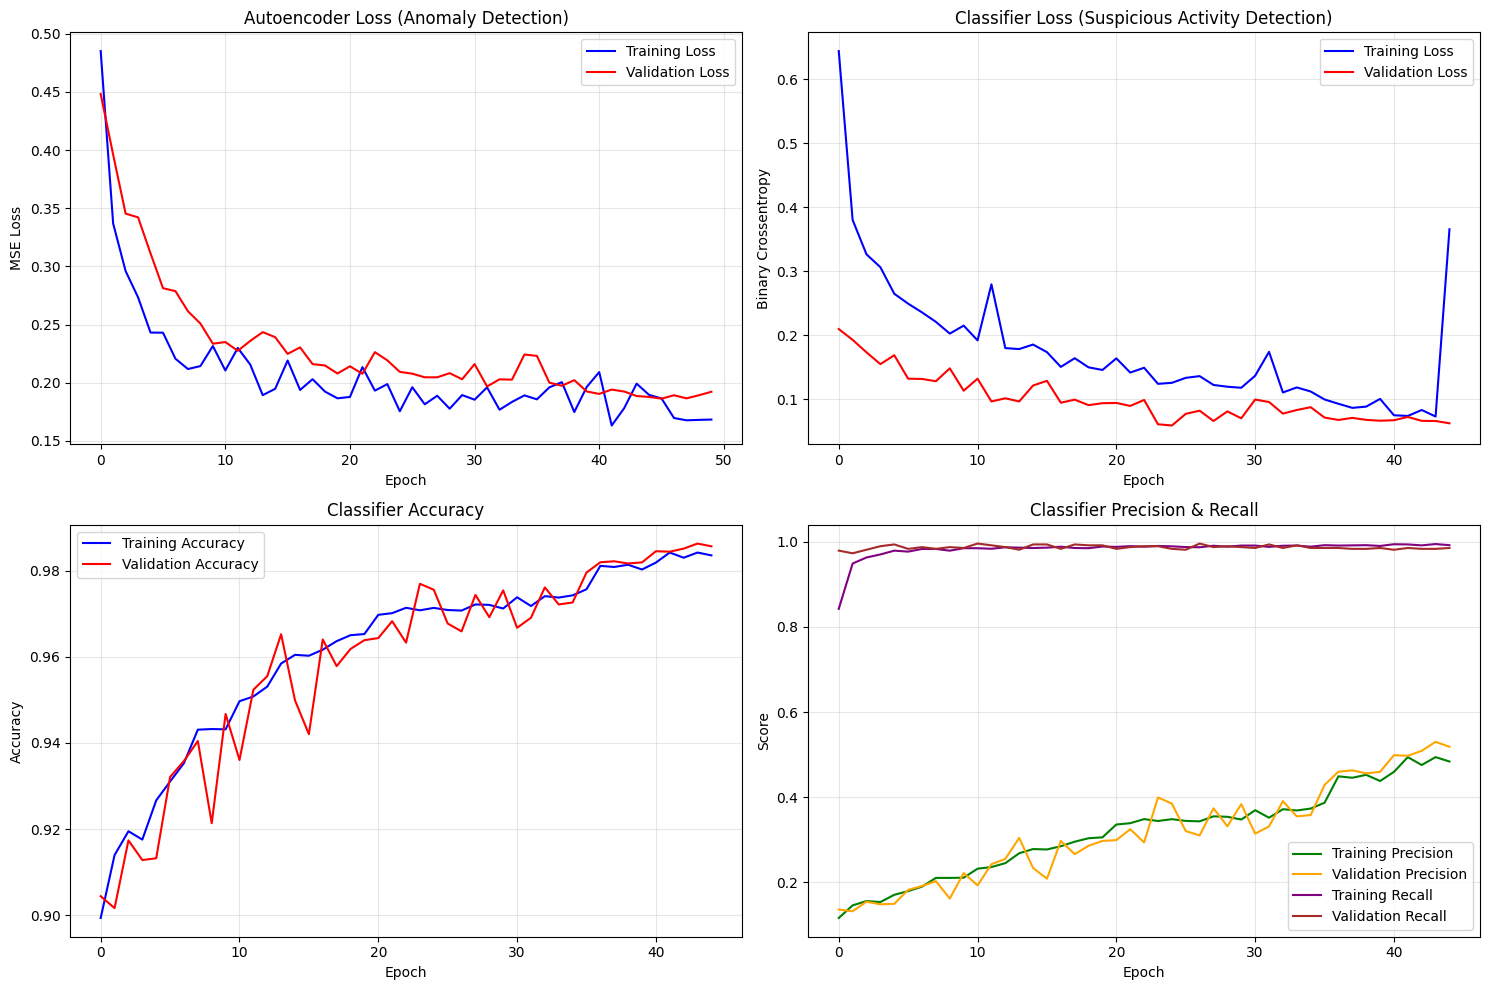

In [25]:
print("\n" + "="*40)
print("TRAINING HISTORY VISUALIZATION")
print("="*40)

# Plot training history
surveillance_model.plot_training_history(history_ae, history_clf)

#### Visualize Precision-Recall vs Threshold

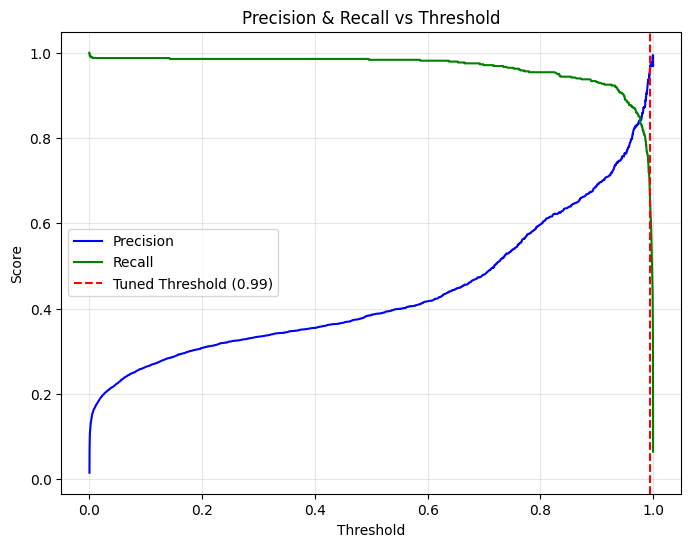

In [ ]:
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_val, val_probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Tuned Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#### Save Models and Export

In [27]:
print("\n" + "="*40)
print("SAVING MODELS AND EXPORTING")
print("="*40)

# Save models for deployment
surveillance_model.save_models()

# Convert to TensorFlow Lite for real-time deployment
surveillance_model.convert_to_tflite(surveillance_model.autoencoder, 'autoencoder')
surveillance_model.convert_to_tflite(surveillance_model.classifier, 'classifier')

print("Models saved and exported successfully!")



SAVING MODELS AND EXPORTING
Models saved: /mnt/e/Programming projects/ML/python/models/market_autoencoder.h5, /mnt/e/Programming projects/ML/python/models/market_classifier.h5
Scaler saved: /mnt/e/Programming projects/ML/python/models/market_scaler.pkl
Feature order saved: /mnt/e/Programming projects/ML/python/models/market_features.json
Configuration saved: /mnt/e/Programming projects/ML/python/models/market_surveillance_config.json
INFO:tensorflow:Assets written to: /tmp/tmp0y1fcib6/assets


INFO:tensorflow:Assets written to: /tmp/tmp0y1fcib6/assets


Saved artifact at '/tmp/tmp0y1fcib6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  128648774692560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774693520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774693328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774694288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774694096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774694672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774694480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648774695056: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved: /mnt/e/Programming projects/ML/python/models/market_autoencoder.tflite
INFO:tensorflow:Assets written to: /tmp/tmptof70lx6/assets


W0000 00:00:1757728321.801121   50775 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757728321.801157   50775 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-12 23:22:01.801380: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp0y1fcib6
2025-09-12 23:22:01.801924: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-12 23:22:01.801928: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp0y1fcib6
I0000 00:00:1757728321.808258   50775 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-09-12 23:22:01.808775: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-12 23:22:01.842437: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp0y1fcib6
2025-09-12 23:22:01.847883: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

Saved artifact at '/tmp/tmptof70lx6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  128648729463312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729474640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729465232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729464656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729465424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729464272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729465040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729476560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729464464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128648729475600: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model s

W0000 00:00:1757728322.431106   50775 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1757728322.431142   50775 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-09-12 23:22:02.431253: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptof70lx6
2025-09-12 23:22:02.431644: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-12 23:22:02.431650: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmptof70lx6
2025-09-12 23:22:02.434770: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-12 23:22:02.456402: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmptof70lx6
2025-09-12 23:22:02.462618: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 31365 microseconds.


#### Demo

In [28]:
print("\n" + "="*60)
print("DEMO: REAL-TIME MARKET SURVEILLANCE")
print("="*60)

# Demo real-time prediction
sample_features = {
    'Price_Change': 0.08,  # 8% price increase
    'Price_Range': 0.12,   # High volatility
    'Gap': 0.02,           # 2% gap
    'Volume_Change': 4.5,  # 450% volume increase
    'Volume_Price_Ratio': 1000.0,
    'Volume_Ratio': 6.0,   # 6x normal volume
    'RSI': 85.0,           # Overbought
    'MACD': 0.5,
    'MACD_Signal': 0.3,
    'MACD_Histogram': 0.2,
    'BB_Width': 0.15,
    'BB_Position': 0.98,   # Near upper Bollinger Band
    'Price_vs_SMA10': 0.1,
    'Price_vs_SMA20': 0.15,
    'Volatility_10d': 0.03,
    'Volatility_20d': 0.025,
    'Hour': 14,            # 2 PM
    'DayOfWeek': 2,        # Wednesday
    'IsMonday': 0,
    'IsFriday': 0
}

print("Sample suspicious trading pattern:")
for key, value in sample_features.items():
    print(f"  {key}: {value}")

prediction = surveillance_model.predict_real_time(sample_features)
print(f"\nPrediction result:")
for key, value in prediction.items():
    print(f"  {key}: {value}")


DEMO: REAL-TIME MARKET SURVEILLANCE
Sample suspicious trading pattern:
  Price_Change: 0.08
  Price_Range: 0.12
  Gap: 0.02
  Volume_Change: 4.5
  Volume_Price_Ratio: 1000.0
  Volume_Ratio: 6.0
  RSI: 85.0
  MACD: 0.5
  MACD_Signal: 0.3
  MACD_Histogram: 0.2
  BB_Width: 0.15
  BB_Position: 0.98
  Price_vs_SMA10: 0.1
  Price_vs_SMA20: 0.15
  Volatility_10d: 0.03
  Volatility_20d: 0.025
  Hour: 14
  DayOfWeek: 2
  IsMonday: 0
  IsFriday: 0

Prediction result:
  ensemble_score: 0.9719724893569947
  anomaly_score: 1
  classifier_probability: 0.9532874226570129
  is_suspicious: True
  risk_level: HIGH
